# CS 7180 Geometric Deep Learning, Homework 4: Steerable CNNs

In [1]:
import os
# I like to use typing, but you don't have to!
from typing import Any, Dict, Tuple, Union

import networkx as nx
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import shift
import scipy.sparse as sp

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import datasets, transforms
from e2cnn import gspaces
from e2cnn import nn as e2cnn_nn

# Interactive plots.
%matplotlib inline

In [2]:
if torch.cuda.is_available() and torch.cuda.device_count() > 0:
  print("PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.")
  device = torch.device("cuda:0")
else:
  print("WARNING: PyTorch running on a CPU.")
  device = torch.device("cpu")

PyTorch running on a GPU. Use '.to(device)' to move tensors and models to GPU.


# Part 1: Training a convolutional network equivariant to discrete rotations. Testing on rotated MNIST.

We will continue with the MNIST dataset from Homework 1. Our goal is to design neural networks that can make good predictions about rotated versions of the MNIST characters when trained only on the original images. For this purpose, we will use original MNIST for training and rotated MNIST for validation.

## Data preprocessing

In [3]:
# Download rotated MNIST.
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

File ‘mnist_rotation_new.zip’ already there; not retrieving.

Archive:  mnist_rotation_new.zip


In [4]:
class MnistRotDataset(torch.utils.data.Dataset):

    def __init__(self, mode: str, transform=None):
        assert mode in ["train", "test"]

        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=" ")

        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)
        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)

    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self) -> int:
        return len(self.labels)

In [5]:
def prepare_mnist(batch_size: int) -> Tuple[DataLoader, DataLoader]:
  """Prepare MNIST training and evaluation data loaders in PyTorch.
  https://github.com/pytorch/examples/blob/main/mnist/main.py
  """
  t = transforms.ToTensor()

  train_ds = datasets.MNIST("/tmp/mnist", download=True, train=True, transform=t)
  eval_ds = datasets.MNIST("/tmp/mnist", download=True, train=False, transform=t)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
  eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=1)

  return train_loader, eval_loader

In [6]:
def prepare_rotated_mnist(batch_size: int) -> Tuple[DataLoader, DataLoader]:
  """Prepare rotated MNIST training and evaluation data loaders in PyTorch.
  https://github.com/QUVA-Lab/e2cnn/blob/master/examples/model.ipynb
  """
  t = transforms.ToTensor()

  train_ds = MnistRotDataset("train", transform=t)
  eval_ds = MnistRotDataset("test", transform=t)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
  eval_loader = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=0)

  return train_loader, eval_loader

### Original MNIST (train_loader, eval_loader)

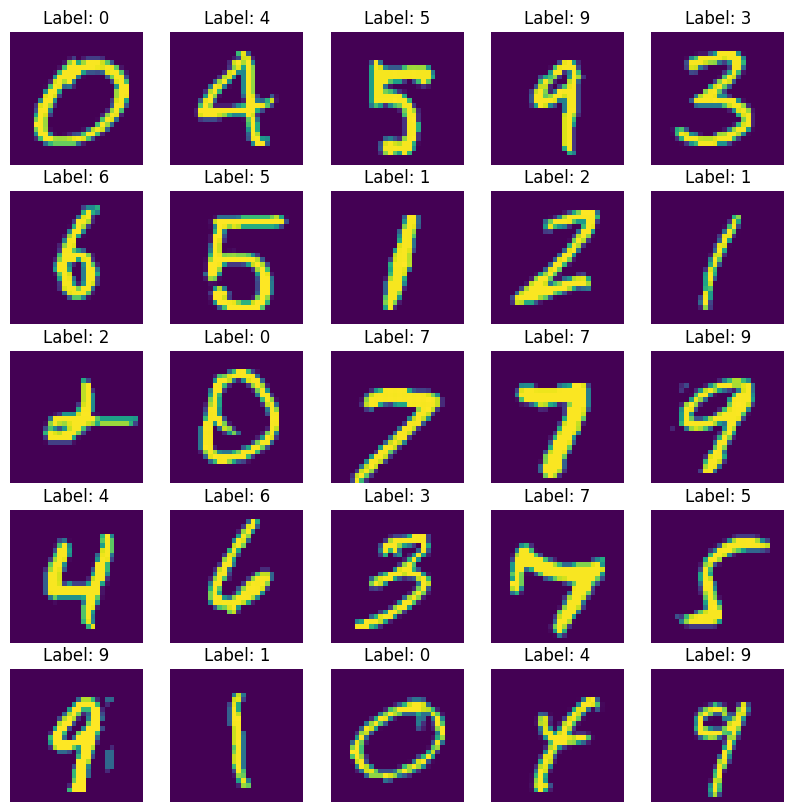

In [7]:
train_loader, eval_loader = prepare_mnist(128)
example = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5*5):
  plt.subplot(5, 5, 1 + i)
  plt.title("Label: {:d}".format(example[1][i]))
  plt.imshow(example[0][i][0])
  plt.axis("off")

### Rotated MNIST (train_rot_loader, eval_rot_loader)

Note that this dataset contains continuous rotations and reflections of the original images.

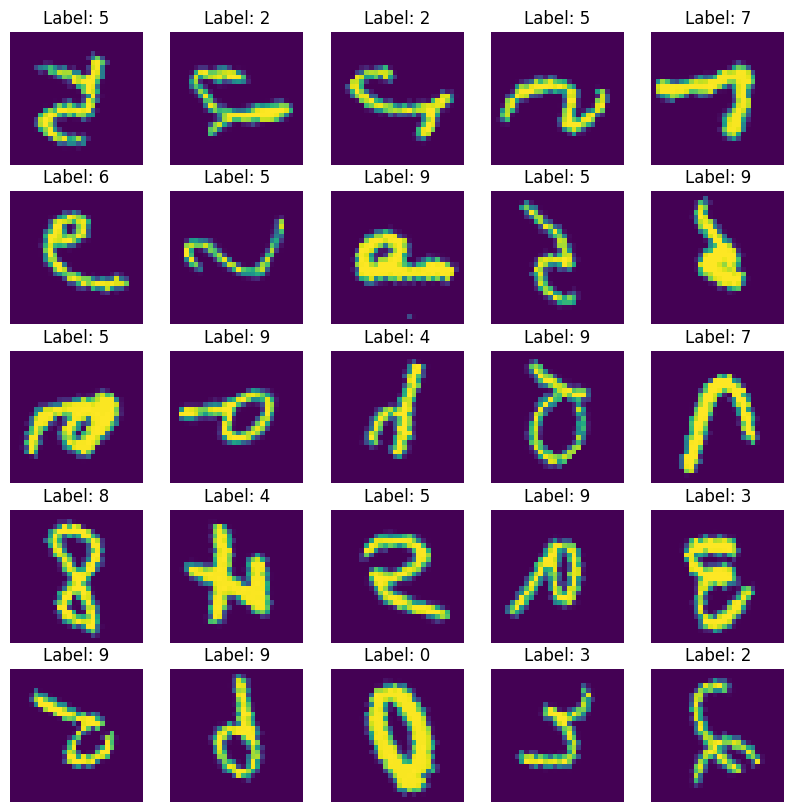

In [8]:
train_rot_loader, eval_rot_loader = prepare_rotated_mnist(128)
example = next(iter(train_rot_loader))
plt.figure(figsize=(10, 10))
for i in range(5*5):
  plt.subplot(5, 5, 1 + i)
  plt.title("Label: {:d}".format(example[1][i]))
  plt.imshow(example[0][i][0])
  plt.axis("off")

## Training a baseline

In [9]:
class CNNBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2), padding=(2,2))
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2),padding=(2,2))
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(5,5), stride=(2,2),padding=(2,2))
        self.linear1 = nn.Linear(256, 128)
        self.linear2 = nn.Linear(128, 10)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.act(self.conv3(x))
        x = self.act(self.conv4(x))

        x = x.reshape(x.shape[0], -1)
        x = self.act(self.linear1(x))
        x = F.log_softmax(self.linear2(x), dim=-1)

        return x

In [10]:
def train(train_loader: DataLoader, model: nn.Module,
          optimizer: optim.Optimizer, epochs: int):

  losses = []
  # 1 epoch = 1 pass through the dataset.
  for epoch in range(epochs):
    print("Epoch {:d} / {:d}".format(epoch, epochs))
    # train_loader steps once it iterates over all data.
    for train_step, batch in enumerate(train_loader):
      # train_loader gives us batched images (CxHxW) and labels (integers).
      # If we are using a GPU we need to move them to the device.
      inputs, labels = batch[0].to(device), batch[1].to(device)
      # Reset last optimization step.
      optimizer.zero_grad()
      # Make prediction, calculate loss.
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, labels)
      # Compute gradients and update weights.
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if train_step > 0 and train_step % 50 == 0:
        print("Mean of last 50 losses: {:f}".format(np.mean(losses[-50:])))

  plt.plot(losses)
  plt.xlabel("Training step")
  plt.ylabel("Loss")

In [11]:
# We don't need gradients during evaluation.
@torch.no_grad()
def evaluate(eval_loader: DataLoader, model: nn.Module):
  model.eval()

  accuracy = []

  for batch in eval_loader:
    inputs, labels = batch[0].to(device), batch[1].to(device)
    outputs = model(inputs)
    pred_labels = torch.argmax(outputs, dim=-1)
    tmp = (labels == pred_labels).float().mean()
    accuracy.append(tmp.item())

  # We compute the mean of means over batches.
  # This could be slightly skewed if the last batch is smaller.
  # Does not matter too much here.
  accuracy = np.mean(accuracy)
  print("Correct answer in {:.1f}% of cases.".format(accuracy * 100))
  return accuracy 

In [12]:
@torch.no_grad()
def plot_predictions(eval_loader: DataLoader, model: nn.Module):
  example = next(iter(eval_loader))
  inputs = example[0].to(device)
  outputs = model(inputs)
  pred_labels = torch.argmax(outputs, dim=-1).to("cpu").numpy()

  plt.figure(figsize=(10, 10))
  for i in range(5*5):
    plt.subplot(5, 5, 1 + i)
    plt.title("Label: {:d}".format(pred_labels[i]))
    plt.imshow(example[0][i][0])
    plt.axis("off")

Epoch 0 / 10
Mean of last 50 losses: 1.160535
Mean of last 50 losses: 0.354450
Mean of last 50 losses: 0.234821
Mean of last 50 losses: 0.187148
Mean of last 50 losses: 0.164816
Mean of last 50 losses: 0.128572
Mean of last 50 losses: 0.128176
Mean of last 50 losses: 0.101255
Mean of last 50 losses: 0.096055
Epoch 1 / 10
Mean of last 50 losses: 0.081986
Mean of last 50 losses: 0.082042
Mean of last 50 losses: 0.069386
Mean of last 50 losses: 0.073777
Mean of last 50 losses: 0.061664
Mean of last 50 losses: 0.073454
Mean of last 50 losses: 0.060703
Mean of last 50 losses: 0.062841
Mean of last 50 losses: 0.059989
Epoch 2 / 10
Mean of last 50 losses: 0.048623
Mean of last 50 losses: 0.043669
Mean of last 50 losses: 0.047256
Mean of last 50 losses: 0.047314
Mean of last 50 losses: 0.052856
Mean of last 50 losses: 0.041759
Mean of last 50 losses: 0.045747
Mean of last 50 losses: 0.049922
Mean of last 50 losses: 0.048741
Epoch 3 / 10
Mean of last 50 losses: 0.035515
Mean of last 50 losses: 

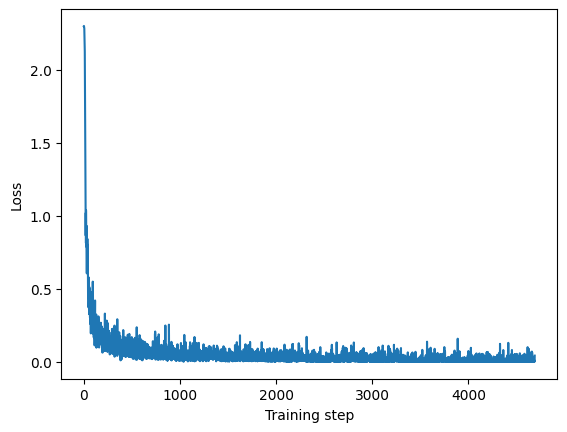

In [13]:
model = CNNBaseline().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(train_loader, model, optimizer, 10)

### Evaluating on the original MNIST dataset

In [14]:
evaluate(eval_loader, model)

Correct answer in 98.8% of cases.


0.9884295886075949

### Evaluating on the rotated MNIST dataset (you should use this one)

In [15]:
evaluate(eval_rot_loader, model)

Correct answer in 26.8% of cases.


0.2675671355651163

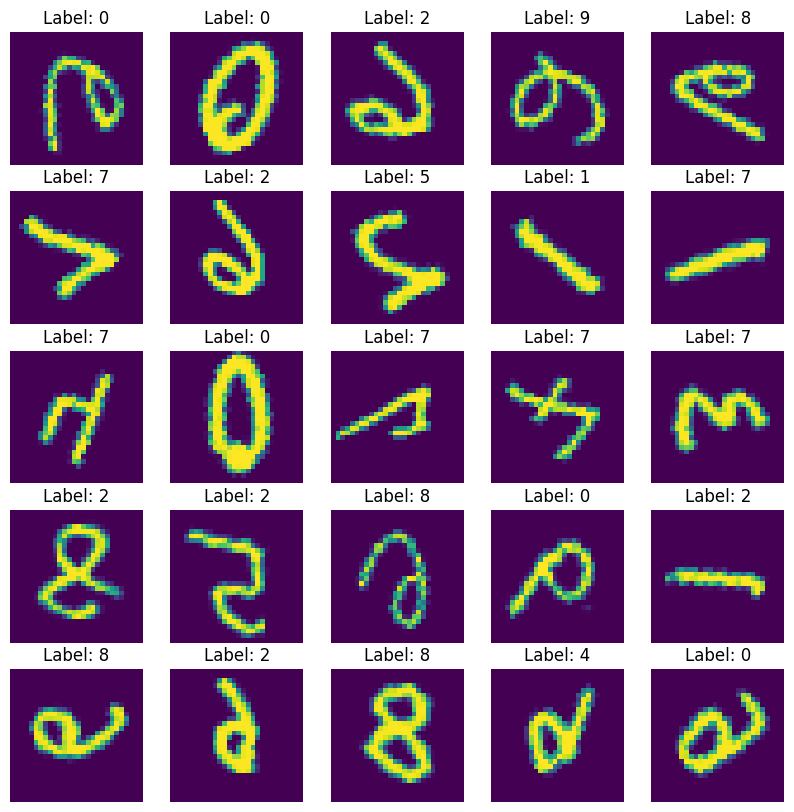

In [16]:
plot_predictions(eval_rot_loader, model)

## == Task 1 ==

[**Question 1**] Implement an C4-invariant (cyclic group -- discrete rotations) convolutional network using the [e2cnn library](https://github.com/QUVA-Lab/e2cnn). You can follow [this tutorial](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/introduction.ipynb). Compare baseline and C4-invarant convolutional networks when trained on MNIST and tested on rotated MNIST. Report learning curves (training step vs training loss) and validation accuracies. Why cannot the baseline CNN classify rotated images well? Does C4-invariance help?

[**Question 2**] Ensure that your C4-invariant convolutional network is invariant to 90 degree rotations of the input image. Describe how you tested the invariance.

[**Question 3**] Implement D1, D2, D4, D8, C2 and C8 invariant convolutional networks and compare their validation accuracies on rotated MNIST to your C4-invariant convolutional network. Dn is the dihedral group (reflections and discrete rotations) and Cn is the cyclic group (discrete rotations). D1 represents reflections only. *I recommend (but it is up to you) that you create a single class and pass arguments for the group order (N) and a boolean argument for including reflections in addition to rotations. The rest should be a simple change to your e2cnn code.*

In [17]:
from e2cnn import gspaces
from e2cnn import nn as enn
import e2cnn

In [18]:
class C4CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super().__init__()
        s = e2cnn.gspaces.Rot2dOnR2(4)
        c_in = e2cnn.nn.FieldType(s, [s.trivial_repr])
        c_hid = e2cnn.nn.FieldType(s, [s.regular_repr]*16)
        c_out = e2cnn.nn.FieldType(s, [s.regular_repr]*32)

        self.conv1 = enn.R2Conv(c_in, c_hid, kernel_size=5, bias=False)
        self.bn1 = enn.InnerBatchNorm(c_hid)
        self.act1 = enn.ReLU(c_hid, inplace=True)
        self.pool = enn.PointwiseMaxPool(c_hid, kernel_size=3, stride=2, padding=1)

        self.conv2 = enn.R2Conv(c_hid, c_hid, kernel_size=5, bias=False)
        # self.bn2 = enn.InnerBatchNorm(c_hid)
        self.act2 = enn.ReLU(c_hid, inplace=True)
        # self.pool = enn.PointwiseMaxPool(c_hid, kernel_size=3, stride=2, padding=1)

        self.conv3 = enn.R2Conv(c_hid, c_out, kernel_size=3, bias=False)
        self.bn3 = enn.InnerBatchNorm(c_out)
        self.act3 = enn.ELU(c_out)

        # Group pooling
        self.gpool = enn.GroupPooling(c_out)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.conv1.in_type)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.gpool(x)

        # Now it's invariant, extract tensor
        x = x.tensor
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)

        return x

Epoch 0 / 10


/home/sakshi/miniforge3/envs/e2cnn_env/lib/python3.9/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:29.)
  full_mask[mask] = norms.to(torch.uint8)


Mean of last 50 losses: 1.099354
Mean of last 50 losses: 0.260969
Mean of last 50 losses: 0.155490
Mean of last 50 losses: 0.130031
Mean of last 50 losses: 0.115051
Mean of last 50 losses: 0.094201
Mean of last 50 losses: 0.080857
Mean of last 50 losses: 0.087440
Mean of last 50 losses: 0.087652
Epoch 1 / 10
Mean of last 50 losses: 0.071857
Mean of last 50 losses: 0.065489
Mean of last 50 losses: 0.079453
Mean of last 50 losses: 0.065109
Mean of last 50 losses: 0.054776
Mean of last 50 losses: 0.055661
Mean of last 50 losses: 0.059985
Mean of last 50 losses: 0.065421
Mean of last 50 losses: 0.066261
Epoch 2 / 10
Mean of last 50 losses: 0.045487
Mean of last 50 losses: 0.048407
Mean of last 50 losses: 0.042824
Mean of last 50 losses: 0.044025
Mean of last 50 losses: 0.054187
Mean of last 50 losses: 0.045273
Mean of last 50 losses: 0.055861
Mean of last 50 losses: 0.053406
Mean of last 50 losses: 0.054300
Epoch 3 / 10
Mean of last 50 losses: 0.039851
Mean of last 50 losses: 0.045101
Mean

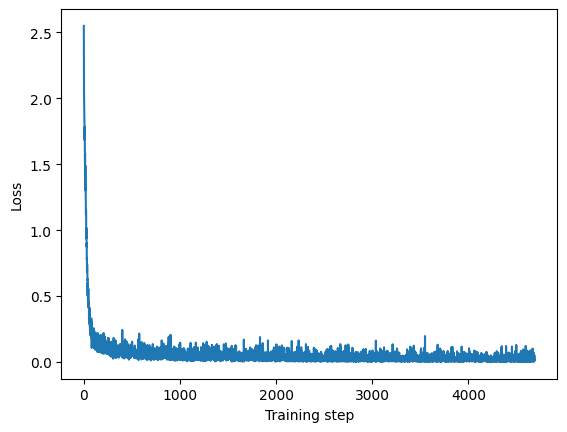

In [19]:
# Training on original dataset
model = C4CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
train(train_loader, model, optimizer, 10)

In [20]:
# Evaluating on original MNIST dataset
evaluate(eval_loader, model)

Correct answer in 98.5% of cases.


0.9852650316455697

In [21]:
# Evaluating on rotated MNIST dataset
c4_eval = evaluate(eval_rot_loader, model)
c4_eval

Correct answer in 46.9% of cases.


0.46903772381565456

[**Question 2**] Ensure that your C4-invariant convolutional network is invariant to 90 degree rotations of the input image. Describe how you tested the invariance.

In [22]:
import torch
import torchvision.transforms.functional as TF
dataiter = iter(train_loader)
images, labels = next(dataiter)

sample_image = images[0]      # shape: [1, 28, 28]
sample_label = labels[0]
print(sample_label)

tensor(3)


In [23]:
x = sample_image.unsqueeze(0)     # (1, 1, H, W)
x = x.to('cuda')
x90  = TF.rotate(x, 90)
x180 = TF.rotate(x, 180)
x270 = TF.rotate(x, 270)

y0_label = torch.argmax(model(x))
y90_label  = torch.argmax(model(x90))
y180_label = torch.argmax(model(x180))
y270_label = torch.argmax(model(x270))
print(y0_label, y90_label, y180_label, y270_label)

tensor(3, device='cuda:0') tensor(3, device='cuda:0') tensor(3, device='cuda:0') tensor(3, device='cuda:0')


## Question 3
Implement D1, D2, D4, D8, C2 and C8 invariant convolutional networks and compare their validation accuracies on rotated MNIST to your C4-invariant convolutional network. Dn is the dihedral group (reflections and discrete rotations) and Cn is the cyclic group (discrete rotations). D1 represents reflections only. *I recommend (but it is up to you) that you create a single class and pass arguments for the group order (N) and a boolean argument for including reflections in addition to rotations. The rest should be a simple change to your e2cnn code.*

In [24]:
class GroupCNN(nn.Module):
    def __init__(self, group_type='D', N=4, num_classes=10, in_channels=1):
        super().__init__()
        # setup gspace
        if group_type == 'C':
            gspace = gspaces.Rot2dOnR2(N)
        elif group_type == 'D':
            if(N==1):
                gspace = gspaces.Flip2dOnR2() # reflections only
            else:
                gspace = gspaces.FlipRot2dOnR2(N)
        else:
            raise ValueError("group_type must be 'C' or 'D'")

        c_in = enn.FieldType(gspace, [gspace.trivial_repr] * in_channels)
        c_hid = e2cnn.nn.FieldType(gspace, [gspace.regular_repr]*16)
        c_out = e2cnn.nn.FieldType(gspace, [gspace.regular_repr]*32)

        self.conv1 = enn.R2Conv(c_in, c_hid, kernel_size=5, bias=False)
        self.bn1 = enn.InnerBatchNorm(c_hid)
        self.act1 = enn.ReLU(c_hid, inplace=True)
        self.pool = enn.PointwiseMaxPool(c_hid, kernel_size=3, stride=2, padding=1)

        self.conv2 = enn.R2Conv(c_hid, c_hid, kernel_size=5, bias=False)
        # self.bn2 = enn.InnerBatchNorm(c_hid)
        self.act2 = enn.ReLU(c_hid, inplace=True)
        # self.pool = enn.PointwiseMaxPool(c_hid, kernel_size=3, stride=2, padding=1)

        self.conv3 = enn.R2Conv(c_hid, c_out, kernel_size=3, bias=False)
        self.bn3 = enn.InnerBatchNorm(c_out)
        self.act3 = enn.ELU(c_out)

        # Group pooling
        self.gpool = enn.GroupPooling(c_out)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.conv1.in_type)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.gpool(x)

        # Now it's invariant, extract tensor
        x = x.tensor
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=-1)

        return x
        

In [25]:
group_list = [
        ("D1", "D", 1),
        ("D2", "D", 2),
        ("D4", "D", 4),
        ("D8", "D", 8),
        ("C2", "C", 2),
        #("C4", "C", 4),
        ("C8", "C", 8),
    ]

In [26]:
import matplotlib.pyplot as plt
val_accuracies = []

In [27]:
val_accuracies.append(("C4", c4_eval))

Training D1 :
Epoch 0 / 3
Mean of last 50 losses: 0.888116
Mean of last 50 losses: 0.217923
Mean of last 50 losses: 0.159431
Mean of last 50 losses: 0.129123
Mean of last 50 losses: 0.105153
Mean of last 50 losses: 0.093613
Mean of last 50 losses: 0.088345
Mean of last 50 losses: 0.081755
Mean of last 50 losses: 0.062876
Epoch 1 / 3
Mean of last 50 losses: 0.072485
Mean of last 50 losses: 0.060618
Mean of last 50 losses: 0.064115
Mean of last 50 losses: 0.060062
Mean of last 50 losses: 0.059572
Mean of last 50 losses: 0.071208
Mean of last 50 losses: 0.061581
Mean of last 50 losses: 0.051786
Mean of last 50 losses: 0.062257
Epoch 2 / 3
Mean of last 50 losses: 0.055512
Mean of last 50 losses: 0.050424
Mean of last 50 losses: 0.051574
Mean of last 50 losses: 0.050692
Mean of last 50 losses: 0.044601
Mean of last 50 losses: 0.055830
Mean of last 50 losses: 0.045435
Mean of last 50 losses: 0.042044
Mean of last 50 losses: 0.055785
Correct answer in 44.6% of cases.
Training D2 :
Epoch 0 / 3

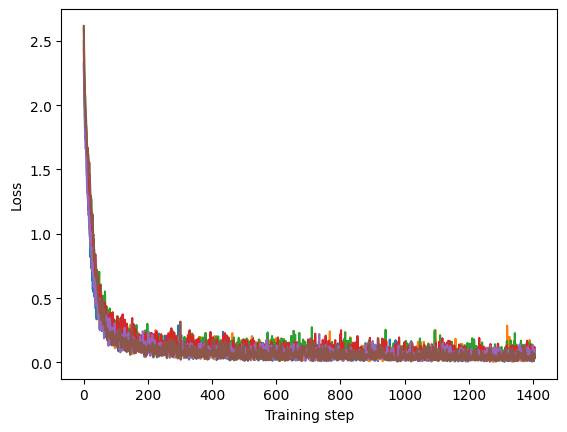

In [28]:
for group in group_list:
    group_name = group[0]  # e.g., "C2", "D4"
    print(f"Training {group_name} :")
    
    # Train
    model = GroupCNN(group_type = group[1], N = group[2]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-2)
    train(train_loader, model, optimizer, 3)

    # Eval
    val_acc = evaluate(eval_rot_loader, model)  
    val_accuracies.append((group_name, val_acc))

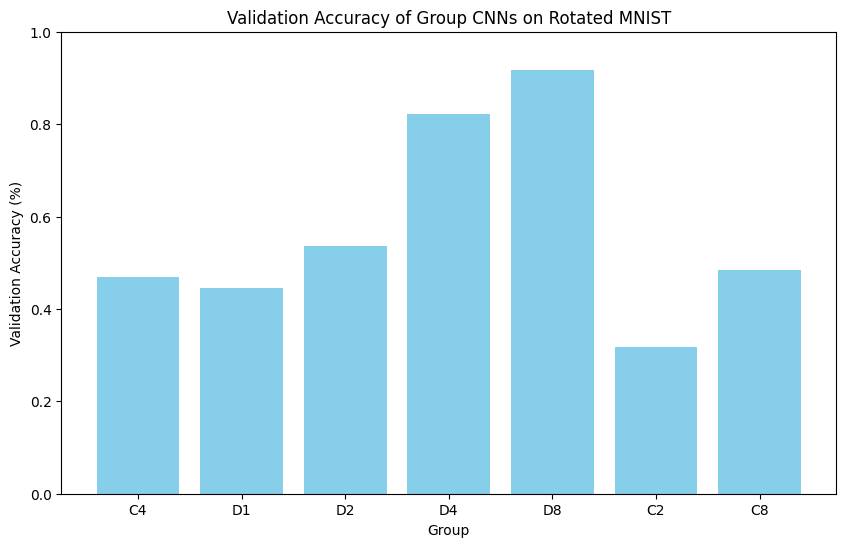

In [29]:
# Unpack for plotting
groups, accs = zip(*val_accuracies)

plt.figure(figsize=(10,6))
plt.bar(groups, accs, color='skyblue')
plt.ylabel("Validation Accuracy (%)")
plt.xlabel("Group")
plt.title("Validation Accuracy of Group CNNs on Rotated MNIST")
plt.ylim(0, 1)
plt.show()

# (Optional!) Part 2: Implementing an SO(2) invariant CNN.

The e2cnn library can implement SO(2)-invariant convolutional networks (approximately invariant to any continuous rotation of the image). We usually approximate equivariance / invariance to continuous rotations using [circular (2D) or spherical (3D) harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics). This approximation, which uses the Fourier basis, however introduces additional complexity in building the model and additional hyper-parameters to tune.

You can start by taking a look at [Table 3 in this paper](https://arxiv.org/abs/1911.08251) and [their associated repository](https://github.com/QUVA-Lab/e2cnn_experiments). In particular, [this bash script](https://github.com/QUVA-Lab/e2cnn_experiments/blob/master/experiments/mnist_bench.sh) has the arguments for [this python file](https://github.com/QUVA-Lab/e2cnn_experiments/blob/master/experiments/models/exp_e2sfcnn.py), which implements several different SO(2)-invariant convolutional networks.

In [70]:
class SO2Invariant(nn.Module):
    def __init__(self, num_classes=10, N=16):
        super().__init__()

        # SO(2) approximated by N sampled rotations
        self.gspace = gspaces.Rot2dOnR2(N)
        self.in_type = enn.FieldType(self.gspace, [self.gspace.trivial_repr])
        self.f1_type = enn.FieldType(self.gspace, 8 * [self.gspace.regular_repr])   # 8 regular fields
        self.f2_type = enn.FieldType(self.gspace, 16 * [self.gspace.regular_repr])  # 16 regular fields
        self.conv1 = enn.R2Conv(self.in_type, self.f1_type, kernel_size=5, padding=2)
        self.relu1 = enn.ReLU(self.f1_type)
        self.pool1 = enn.PointwiseAvgPool(self.f1_type, kernel_size=2, stride=2)
        self.conv2 = enn.R2Conv(self.f1_type, self.f2_type, kernel_size=5, padding=2)
        self.relu2 = enn.ReLU(self.f2_type)
        self.pool2 = enn.PointwiseAvgPool(self.f2_type, kernel_size=2, stride=2)
        self.gpool = enn.GroupPooling(self.f2_type)

        # After GroupPooling, feature type is:
        #   FieldType(gspace, [trivial_repr] * 16)
        self.inv_type = self.gpool.out_type
        self.adapt = enn.PointwiseAdaptiveAvgPool(self.inv_type, output_size=1)

        # Number of invariant channels = len(inv_type.representations)
        self.num_invariant_channels = len(self.inv_type.representations)
        self.fc = nn.Linear(self.num_invariant_channels, num_classes)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.in_type)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Make invariant
        x = self.gpool(x)
        # Spatial 1×1
        x = self.adapt(x)
        # Convert to normal tensor: (B, C, 1, 1) → (B, C)
        x = x.tensor.view(x.tensor.size(0), -1)
        return self.fc(x)


Epoch 0 / 10
Mean of last 50 losses: 2.126970
Mean of last 50 losses: 1.456758
Mean of last 50 losses: 1.096154
Mean of last 50 losses: 0.896871
Mean of last 50 losses: 0.779618
Mean of last 50 losses: 0.717860
Mean of last 50 losses: 0.628370
Mean of last 50 losses: 0.574667
Mean of last 50 losses: 0.563899
Epoch 1 / 10
Mean of last 50 losses: 0.496310
Mean of last 50 losses: 0.512330
Mean of last 50 losses: 0.473710
Mean of last 50 losses: 0.445517
Mean of last 50 losses: 0.431368
Mean of last 50 losses: 0.401739
Mean of last 50 losses: 0.403183
Mean of last 50 losses: 0.385428
Mean of last 50 losses: 0.391473
Epoch 2 / 10
Mean of last 50 losses: 0.355290
Mean of last 50 losses: 0.338732
Mean of last 50 losses: 0.359742
Mean of last 50 losses: 0.356803
Mean of last 50 losses: 0.355119
Mean of last 50 losses: 0.339859
Mean of last 50 losses: 0.351257
Mean of last 50 losses: 0.336022
Mean of last 50 losses: 0.314474
Epoch 3 / 10
Mean of last 50 losses: 0.308216
Mean of last 50 losses: 

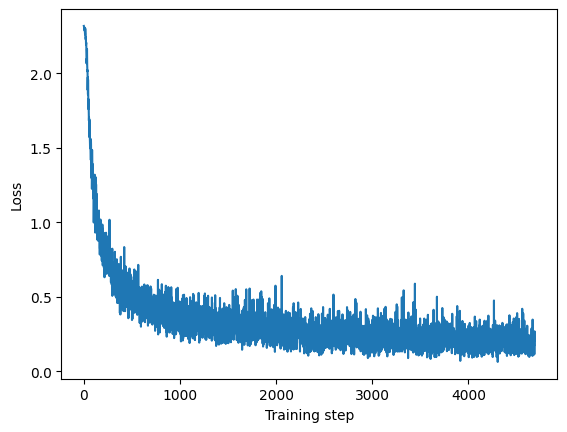

In [73]:
model = SO2Invariant().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-2)
train(train_loader, model, optimizer, 10)

In [74]:
# Evaluating on rotated MNIST dataset
so2_eval = evaluate(eval_rot_loader, model)
so2_eval

Correct answer in 51.6% of cases.


0.5155890346183192